---
## Install and import libraries as needed

In [1]:
# install fuzzy c means
'''import sys
!{sys.executable} -m pip install scikit-fuzzy'''

# install plotly
'''import sys
!{sys.executable} -m pip install plotly'''

'import sys\n!{sys.executable} -m pip install plotly'

In [2]:
import skfuzzy as fuzz
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
import plotly.express as px

%load_ext autoreload
%autoreload 2

font = {'family' : 'helvetica','size'   : 18}
plt.rc('font', **font) 

---
## Double Gyre Data gen.

In [3]:
# constants
A = 0.25
epsilon = 0.25
w = np.pi*2 #/10

# horizontal comp.
def f(x,t):
    return epsilon*np.sin(w*t)*(x**2) + (1-2*epsilon*np.sin(w*t))*x

def u_gyre(x,y,t):
    return -np.pi*A*np.sin(np.pi*f(x,t))*np.cos(np.pi*y)

def v_gyre(x,y,t):
    return ((2*epsilon*np.sin(w*t)*x 
            + 1-2*epsilon*np.sin(w*t))*np.sin(np.pi*y)*np.pi*A*np.cos(np.pi*f(x,t)))

# function for random data init 

def rand_trace_double_gyre(Nx, Ny, final_t=20, no_t_step=201):
    
    x0 = np.linspace(0, 2, Nx)
    y0 = np.linspace(0, 1, Ny)
    
    x0, y0 =np.meshgrid(x0,y0)
    
    # time steps
    times, dt = np.linspace(0,final_t, no_t_step, retstep = True)

    # init arrays for point data
    x_pos = []
    y_pos = []

    # maybe add noise to this?

    # now reshape
    x = x0
    y = y0

    # save positions
    x_pos.append(x0)
    y_pos.append(y0)

    # loop through each time step
    for t in times:
        x1 = x + u_gyre(x,y,t)*dt
        y1 = y + v_gyre(x,y,t)*dt

        # save positions
        x_pos.append(x1)
        y_pos.append(y1)

        y = np.copy(y1)
        x = np.copy(x1)
        
    return x_pos, y_pos, dt

def rand_trace_double_gyre_old(M, final_t = 20, no_t_step = 201):

    # generate initial coords
    # draw in interval [0,1] to see it at work
    x0 = np.random.uniform(0,2,M)
    #x0 = (x0 - 0.5)*NX

    y0 = np.random.uniform(0,1,M)
    #y0 = (y0 - 0.5)*NY

    # time steps
    times, dt = np.linspace(0,final_t, no_t_step, retstep = True)

    # init arrays for point data
    x_pos = []
    y_pos = []

    # maybe add noise to this?

    # now reshape
    x = x0
    y = y0

    # save positions
    x_pos.append(x0)
    y_pos.append(y0)

    # loop through each time step
    for t in times:
        x1 = x + u_gyre(x,y,t)*dt
        y1 = y + v_gyre(x,y,t)*dt

        # save positions
        x_pos.append(x1)
        y_pos.append(y1)

        y = np.copy(y1)
        x = np.copy(x1)
        
    return x_pos, y_pos, dt

# number of data points 
M = 55**2
# M = 23**2
# M = 80**2

# end time
final_time = 10

# for a test
# final_time = 5

Nx = 128
Ny = 128

# Nx = 256
# Ny = 256

x_pos, y_pos, dt = rand_trace_double_gyre(Nx, Ny, final_time, 201)

# # especially for high res
# point_size = 0.5

# for lower res
point_size = 3
    
# plotting
plt.figure(figsize=(12,8))
plt.scatter(x_pos[0], y_pos[0], color='c', 
            label = 'Initial Position', 
            alpha = 0.7, s=point_size)
plt.scatter(x_pos[-1], y_pos[-1], color='r', 
            label = 'Final posiiton',
            alpha = 0.7, s=point_size)
plt.legend(bbox_to_anchor=(1.005,1))
plt.title(f'Simulated double gyre flow on a {Nx}x{Ny} grid over {final_time} seconds.')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

In [4]:
def entropy_calc(x):
    '''
    function to calculate entropy of a results set
    '''
    n = len(x)
    y = x*np.log(x)
    return -(np.sum(y)) / n

In [5]:
# plotting different liklihood values
def plot_cluster_likelihoods(x, y, u, fig_dim = (12,12), point_size = 50):
    
    #fig, axes = plt.subplots(u.shape[0], 1, sharex=True, figsize=(16,10))
    
    print(f'\nThe likelihood plots for {u.shape[1]} clusters are as follows: \n')
    
    # create bins
    bins = np.linspace(0,1,11)
    
    # loop through each cluster
    for i in range(u.shape[1]):
        
        # extract cluster likelihood
        cluster_u = u[:,i]
        
        # bin u values
        u_binned = np.digitize(cluster_u, bins)

        # plotting
        plt.figure(figsize=fig_dim)

        sns.scatterplot(x=x_dat,
                        y=y_dat,
                        hue=u_binned,
                        palette='plasma',
                        alpha=0.7,
                        legend='full',
                        s = point_size)

        plt.title(f'Cluster {i+1} membership likelihood values')
        plt.legend(np.round(bins[1:],1), title='Likelihood Value', bbox_to_anchor=(1.005,1))
        plt.xlabel('x')
        plt.ylabel('y')
        plt.grid()
        plt.tight_layout()
    plt.show()
    
    print('-------------------------------------------------------------------------------------------------\n')

In [6]:
# plotting different liklihood values
def plot_cluster_likelihoods_alt(x, y, u, fig_dim = (14,6), point_size = 50):
    
    #fig, axes = plt.subplots(u.shape[0], 1, sharex=True, figsize=(16,10))
    
    print(f'\nThe likelihood plots for {u.shape[1]} clusters are as follows: \n')
    
    x0 = np.linspace(0, 2, Nx)
    y0 = np.linspace(0, 1, Ny)
    
    # create bins
    bins = np.linspace(0,1,11)
    
    # loop through each cluster
    for i in range(u.shape[1]):
        
        # extract cluster likelihood
        cluster_u = u[:,i]
        
        u2d = np.reshape(cluster_u, (Nx,Ny))

        # plotting
        plt.figure(figsize=fig_dim)       
        plt.pcolormesh(x0,y0,u2d, cmap='plasma')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.colorbar()
        # plt.clim((0,1))
        plt.show()
    
    print('-------------------------------------------------------------------------------------------------\n')

In [8]:
# from numba import njit

# forming trajectory matrix
x_pos, y_pos = np.array(x_pos), np.array(y_pos)

def make_traj(x_pos, y_pos):

    # total number of positions in each trajectory
    total_ent = x_pos[0].flatten().shape[0]

    # no timesteps
    no_tsteps = len(x_pos)

    # initialise array to hold all x coordinates
    x_traj_mat = np.array([])

    x_traj_mat = 1000*np.ones(no_tsteps)

    # init holder matrix
    hold = np.zeros(len(x_pos))

    # loop through each position in the trajectory
    for j in range(total_ent):

        # loop through each step of trajectory
        for i in range(no_tsteps):
            # put x positions in holder array
            hold[i] = (x_pos[i].flatten())[j]

        x_traj_mat = np.vstack((x_traj_mat,hold))

    x_traj_mat = x_traj_mat[1:,:]

    y_traj_mat = 1000*np.ones(no_tsteps)

    # loop through each position in the trajectory
    for j in range(total_ent):

        # loop through each step of trajectory
        for i in range(no_tsteps):
            hold[i] = (y_pos[i].flatten())[j]

        y_traj_mat = np.vstack((y_traj_mat,hold))

    y_traj_mat = y_traj_mat[1:,:]

    ### now in form x_{i,t}, ..., x_{i,T}, ..., y_{i,1}, ..., y_{i,T}

    # initialise trajectory matrix
    traj_mat = np.zeros((x_traj_mat.shape[0], x_traj_mat.shape[1]*2))
    
    # loop through each trajectory
    for i in range(x_traj_mat.shape[0]):
        # loop through each position in the trajectory
        for j in range(0, x_traj_mat.shape[1]):
            # store x position
            traj_mat[i,j] = x_traj_mat[i,j]
            # store y position
            traj_mat[i,j+x_traj_mat.shape[1]] = y_traj_mat[i,j]
            
    return traj_mat

traj_mat = make_traj(x_pos, y_pos)

---
## Fuzzy C-means clustering


The likelihood plots for 8 clusters are as follows: 



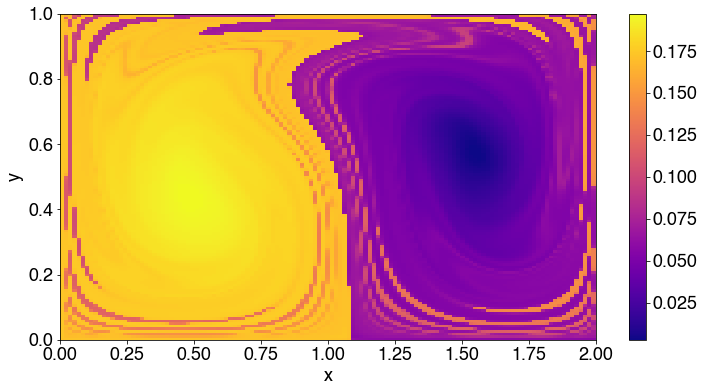

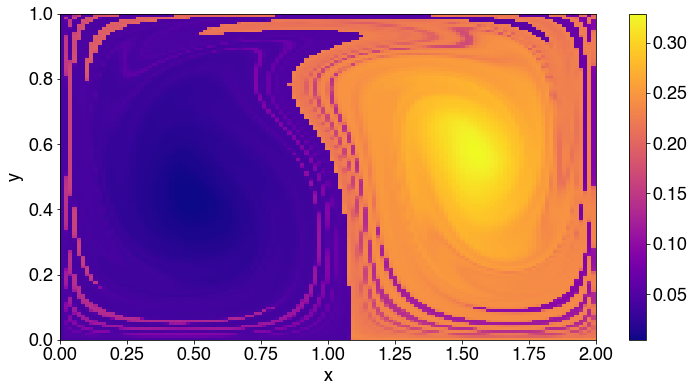

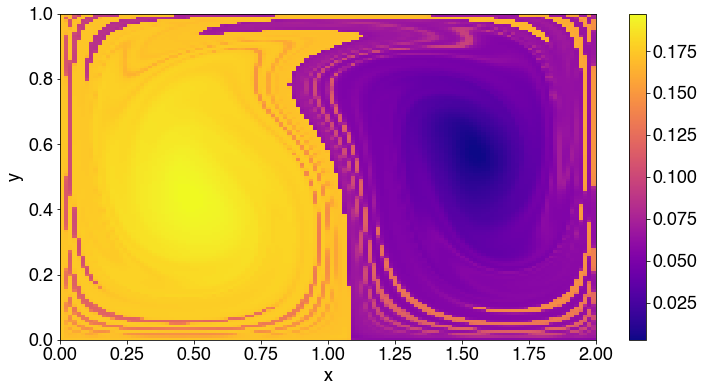

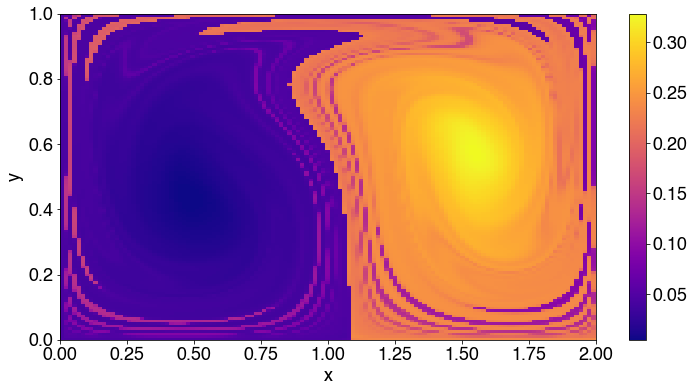

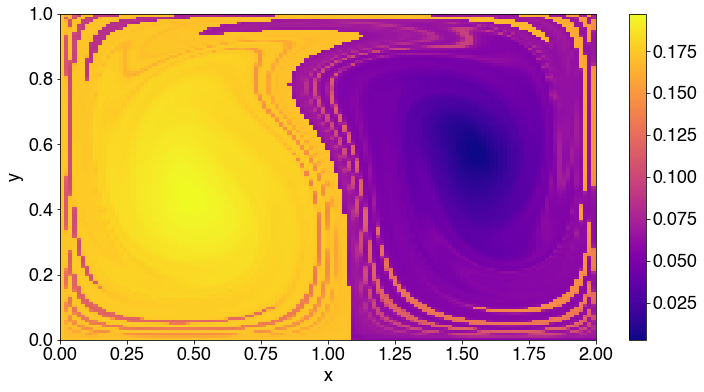

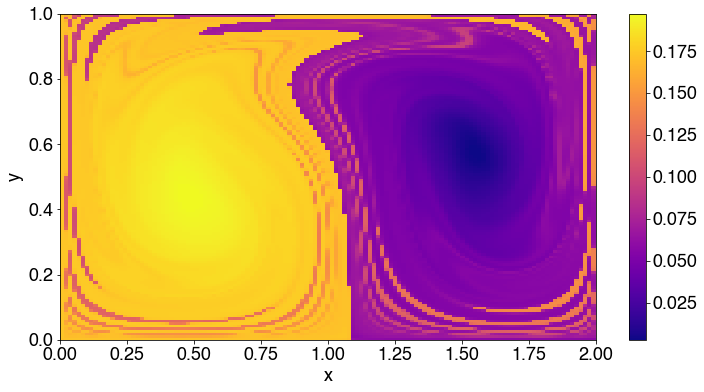

-------------------------------------------------------------------------------------------------


The likelihood plots for 7 clusters are as follows: 



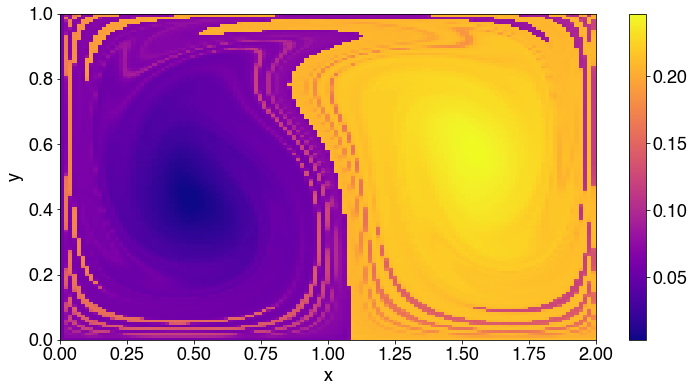

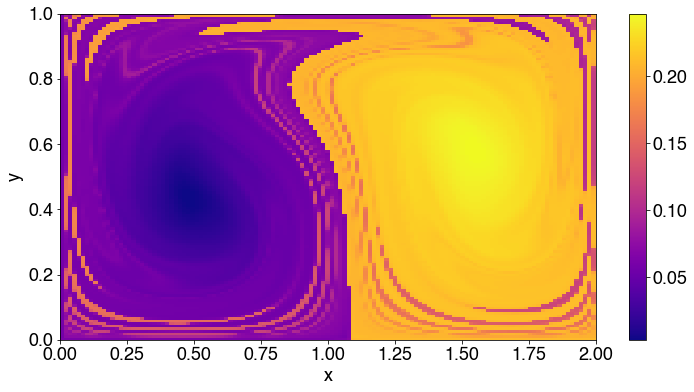

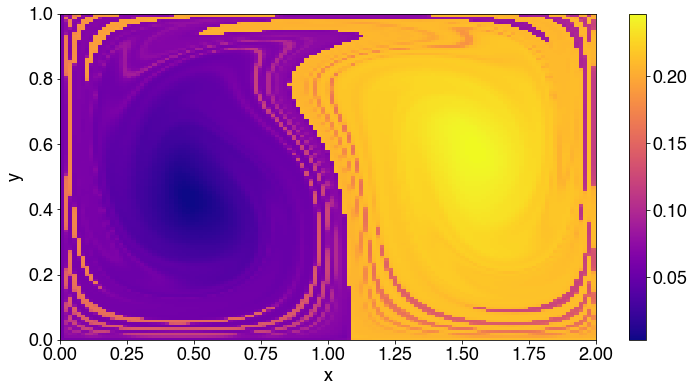

-------------------------------------------------------------------------------------------------


The likelihood plots for 6 clusters are as follows: 



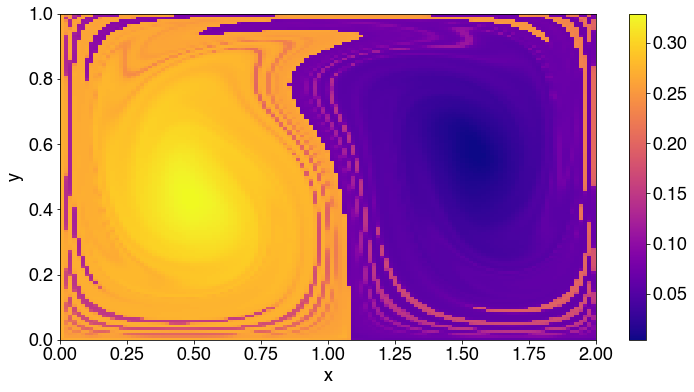

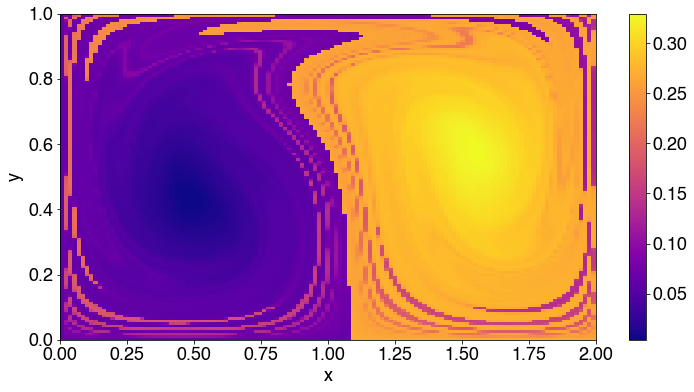

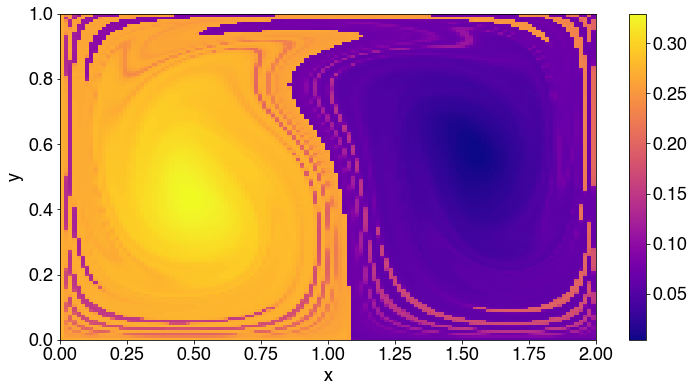

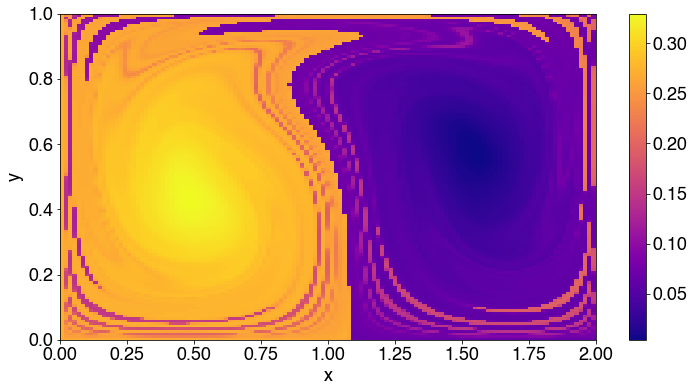

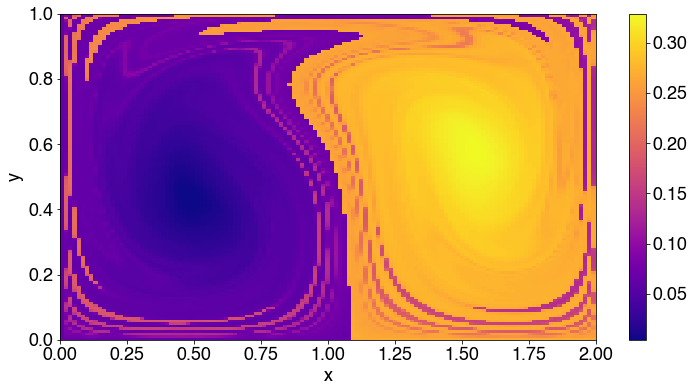

-------------------------------------------------------------------------------------------------


The likelihood plots for 5 clusters are as follows: 



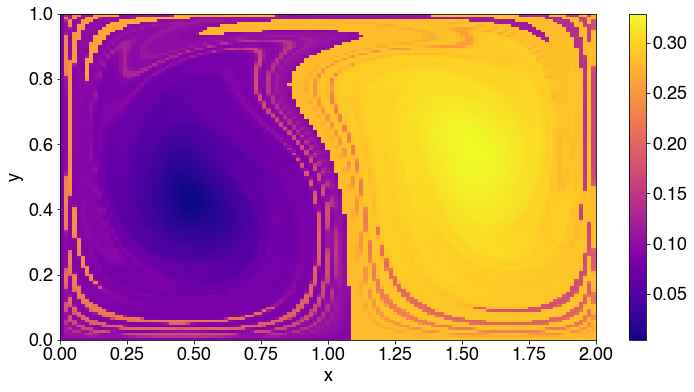

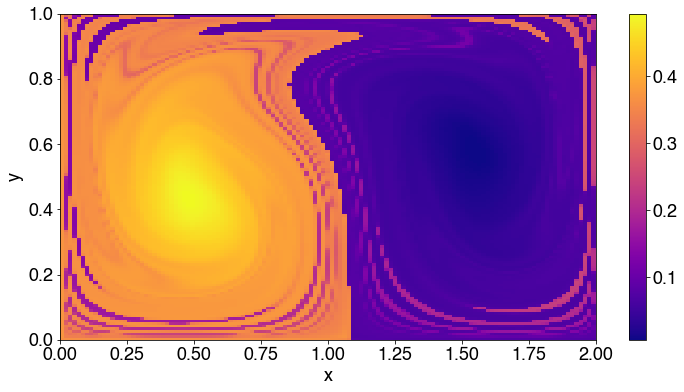

-------------------------------------------------------------------------------------------------


The likelihood plots for 4 clusters are as follows: 



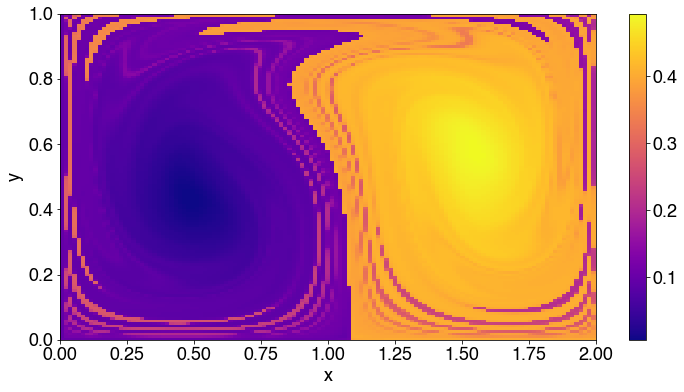

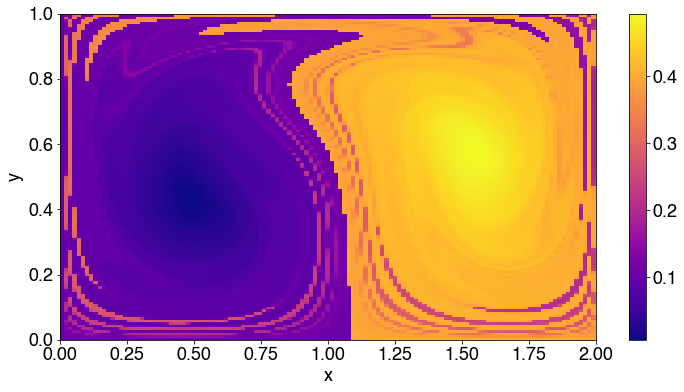

-------------------------------------------------------------------------------------------------


The likelihood plots for 3 clusters are as follows: 



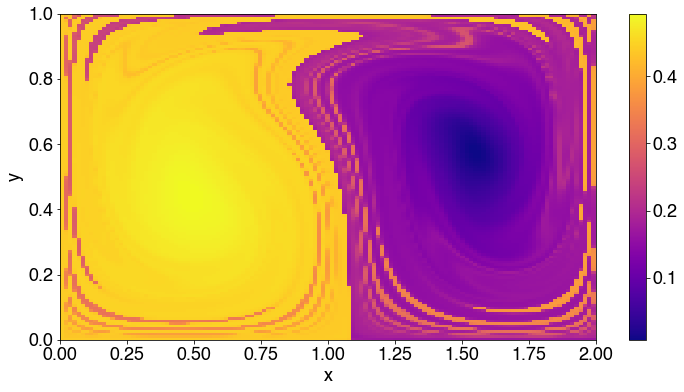

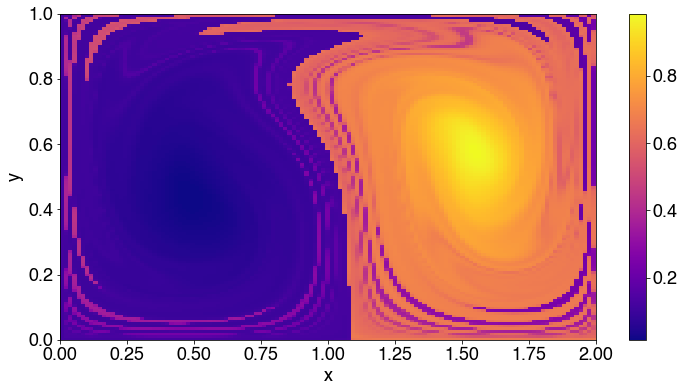

-------------------------------------------------------------------------------------------------


The likelihood plots for 2 clusters are as follows: 



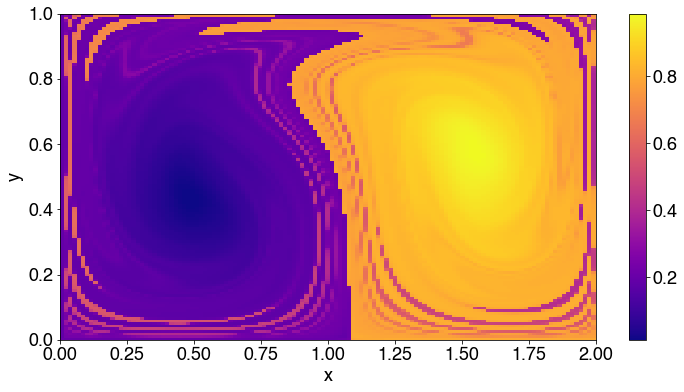

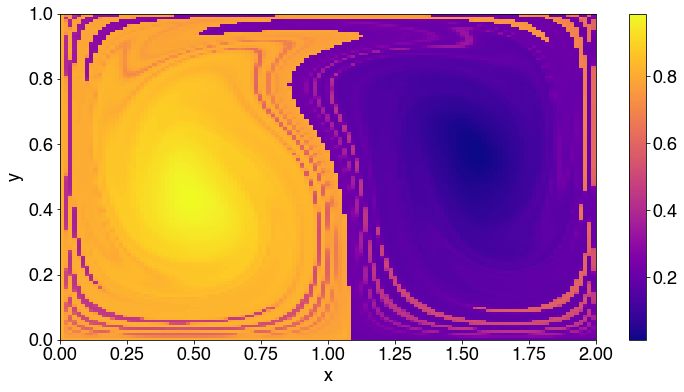

-------------------------------------------------------------------------------------------------



In [9]:
# number of clusters
no_clusters_list = [8,7,6,5,4,3,2]

# no_clusters_list = [3,2]

fpc_dict = {}
pe_dict = {}

# final x and y positions - easier visualisation
x_dat = x_pos[0].flatten()
y_dat = y_pos[0].flatten()

# loop through number of clusters
for no_clusters in no_clusters_list:
    
    # fuzzy c-means
    fuzzy_result = fuzz.cluster.cmeans(traj_mat.T,
                              no_clusters,
                              m=2,
                              error=10**(-3),
                              maxiter= 10**4)
    
    u = fuzzy_result[1].T
    
    plot_cluster_likelihoods_alt(x_dat, y_dat, u, (12,6), 20)
    
    entropy = np.apply_along_axis(entropy_calc, 0, u)
    
    fpc_dict[no_clusters] = fuzzy_result[-1]
    
    pe_dict[no_clusters] = np.sum(entropy)
    

In [10]:
plt.figure(figsize = (14,6))
plt.subplot(121)
plt.scatter(fpc_dict.keys(), fpc_dict.values(), alpha = 0.8, c='deepskyblue')
plt.xlabel('Number of clusters')
plt.ylabel('Fuzzy partition coefficient')
plt.grid()

plt.subplot(122)
plt.scatter(pe_dict.keys(), pe_dict.values(), alpha = 0.8, c='salmon')
plt.xlabel('Number of clusters')
plt.ylabel('Partition entropy')
plt.grid()
plt.tight_layout()
plt.show()

---
## Plot trajectories

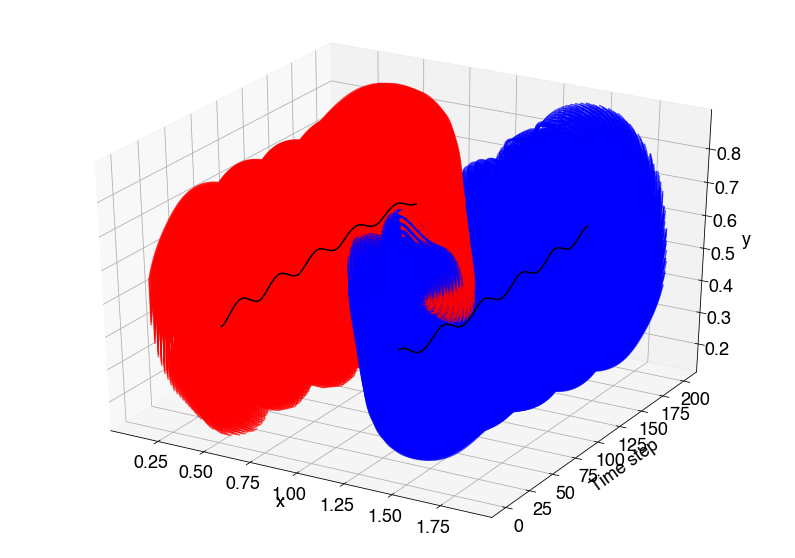

In [308]:
### identify trajectories with membership likelihood greater than some threshold
# %matplotlib notebook
# %matplotlib notebook
# %matplotlib inline

# get fuzzy matrix - correct shape
u = fuzzy_result[1].T

# set likelihood threshold
u_threshold = 0.9

# make entries below threshold 0
u_cert = np.where(u >= u_threshold, u, 0)

# get trajectories where likelihood non-zero now
# Note: np.where returns 2 array (1st is column position, 2nd row position)
confident_traj = traj_mat[np.where(u_cert != 0)[0],:]

hue_traj = np.where(u_cert != 0)[1]

### 3D plotting

# create figure
fig = plt.figure(figsize = (14,10))
ax = plt.axes(projection='3d')

# find length of one trajectory
x_traj_length = x_traj_mat[0,:].shape[0]

# clusters 
clusters = fuzzy_result[0]

# number of clusters
no_clusters = clusters.shape[0]

# time steps
t_traj = np.arange(x_traj_length)

# manual hueing
hueing = []

for val in hue_traj:
    if val == 1:
        hueing.append('blue')
    else:
        hueing.append('red')

# loop through trajectories and plot them
for i in range(confident_traj.shape[0]):
    
    # x trajectory
    x_traj = confident_traj[i,:x_traj_length]
    
    # y trajectory
    y_traj = confident_traj[i,x_traj_length:]
    
    # plot trajectories
    ax.plot3D(x_traj, t_traj, y_traj, c=hueing[i], alpha=0.7)

# loop through clusters and plot them
for i in range(no_clusters):
    
    # x trajectory
    x_traj = clusters[i,:x_traj_length]
    
    # y trajectory
    y_traj = clusters[i,x_traj_length:]
    
    # plot clusters
    ax.plot3D(x_traj, t_traj, y_traj, 'k', alpha=1)
    
# graph formatting
ax.set_xlabel('x')
ax.set_ylabel('Time step')
ax.set_zlabel('y')

plt.show()

---
## Likelihood membership plots

In [166]:
# membership of trajectory to 1 cluster - as we are only 2 clustering this is complete info
u_single = u[:,0]

# final x and y positions - easier visualisation
x_dat = x_pos[0].flatten()
y_dat = y_pos[0].flatten()

# plotting
fig = plt.figure(figsize=(14,10))
ax = plt.axes(projection='3d')
ax.scatter3D(x_dat, y_dat, u_single, c='salmon', alpha=0.7)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Likelihood');

In [167]:
# membership visualisation
# %matplotlib inline

# create bins
bins = np.linspace(0,1,11)

# membership of trajectory to 1 cluster - as we are only 2 clustering this is complete info
u_single = u[:,0]

# bin u values
u_binned = np.digitize(u_single, bins)

# plotting
plt.figure(figsize=(14,8))

sns.scatterplot(x=x_dat,
                y=y_dat,
                hue=u_binned,
                palette='plasma',
                alpha=0.7)

plt.title('Cluster membership of trajectories by final particle position')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.tight_layout()
plt.show()

In [256]:
# membership visualisation

# create bins
bins = np.linspace(0,1,11)

# membership of trajectory to 1 cluster - as we are only 2 clustering this is complete info
u_single = u[:,0]

# bin u values
u_binned = np.digitize(u_single, bins)

point_size = 16

# plotting
plt.figure(figsize=(12,6))

sns.scatterplot(x=x_dat,
                y=y_dat,
                hue=u_binned,
                palette='plasma',
                alpha=0.7,
                s=point_size,
                legend='full')

#plt.title('Cluster membership of trajectories by final particle position')
plt.legend(np.round(bins[1:],1), title='Likelihood Value', bbox_to_anchor=(1.005,1))
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

In [309]:
# reshape u
u_2d = np.reshape(u_single, (Nx,Ny))

x0 = np.linspace(0, 2, Nx)
y0 = np.linspace(0, 1, Ny)

plt.figure(figsize=(14,6))
plt.pcolormesh(x0, y0, u_2d, cmap='plasma')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

---
## Entropy plot

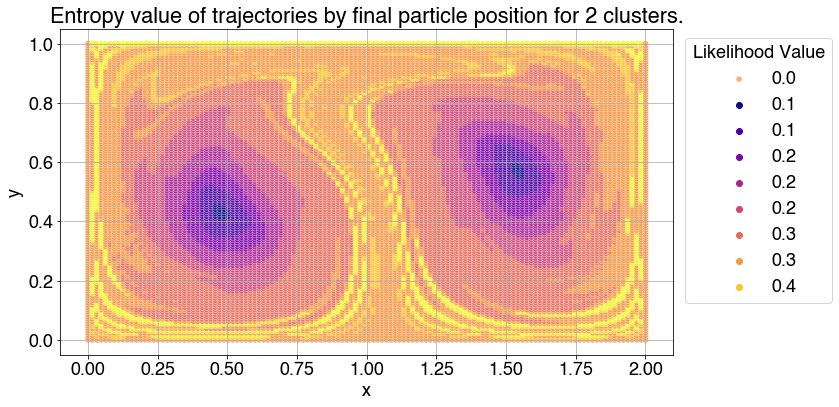

In [13]:
# calculate entropy
entropy = np.apply_along_axis(entropy_calc, 1, u)

# create bins
bins = np.linspace(0, max(entropy)+0.01, 10)

# bin u values
entropy_binned = np.digitize(entropy, bins)

# plotting
plt.figure(figsize=(12,6))

# plot data
sns.scatterplot(x=x_dat,
                y=y_dat,
                hue=entropy_binned,
                palette='plasma',
                alpha=0.7,
                legend='full')

plt.title(f'Entropy value of trajectories by final particle position for 2 clusters.')
plt.legend(np.round(bins[1:],1), title='Likelihood Value', bbox_to_anchor=(1.005,1))
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.tight_layout()

plt.show()

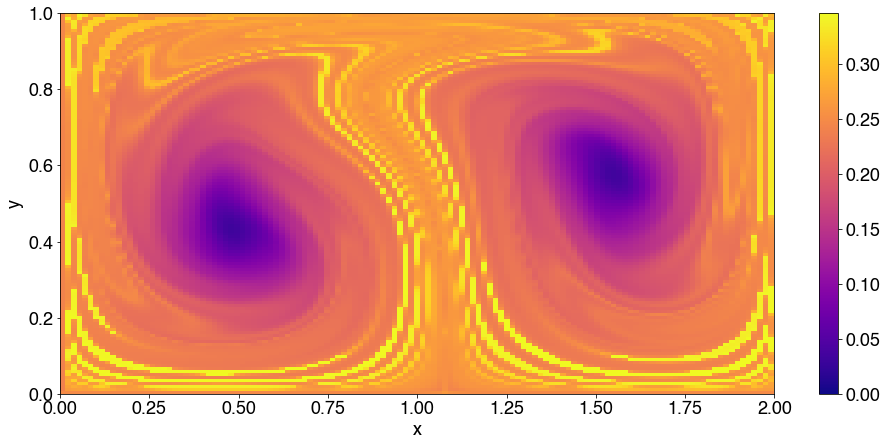

In [311]:
entropy2d = np.reshape(entropy, (Nx,Ny))

x0 = np.linspace(0, 2, Nx)
y0 = np.linspace(0, 1, Ny)

plt.figure(figsize=(16,7))
plt.pcolormesh(x0,y0, entropy2d, cmap='plasma', shading='auto')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.clim((0,np.max(entropy2d)))
plt.show()

In [319]:
partition_entropy = np.sum(entropy)
partition_entropy

3725.4232422986142

---
## Pendulum flow for example

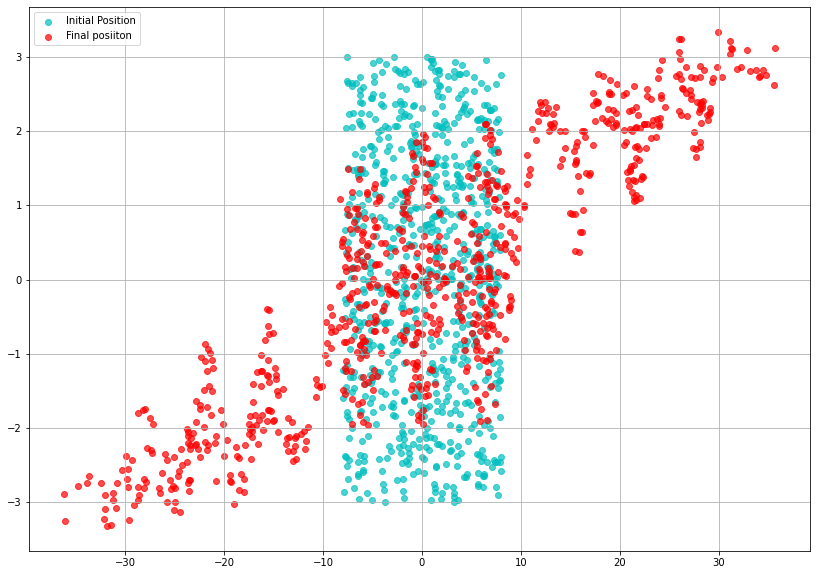

In [12]:
# function for random data init 

def rand_trace_pend(M, NX, NY, final_t = 10, no_t_step = 2000):

    # generate initial coords
    x0 = np.random.rand(M)
    x0 = (x0 - 0.5)*NX

    y0 = np.random.rand(M)
    y0 = (y0 - 0.5)*NY

    # time steps
    times, dt = np.linspace(0,final_t, no_t_step, retstep = True)

    # init arrays for point data
    x_pos = []
    y_pos = []

    # maybe add noise to this?

    # now reshape
    x = x0
    y = y0

    # save positions
    x_pos.append(x0)
    y_pos.append(y0)

    # loop through each time step
    for t in times:
        x1 = x + y*dt
        y1 = y - np.sin(x)*dt

        # make sure points wrap around the domain
        #x1 = wrap_domain(x1, -NX/2, NX, centred=True)

        # save positions
        x_pos.append(x1)
        y_pos.append(y1)

        y = np.copy(y1)
        x = np.copy(x1)
        
    return x_pos, y_pos

# number of data points 
# M = 8**2
M = 28**2

# interval length in x and y direction
NX = 16
NY = 6

x_pos, y_pos = rand_trace_pend(M, NX, NY)
    
# plotting
plt.figure(figsize=(14,10))
plt.scatter(x_pos[0], y_pos[0], color='c', 
            label = 'Initial Position', 
            alpha = 0.7)
plt.scatter(x_pos[-1], y_pos[-1], color='r', 
            label = 'Final posiiton',
            alpha = 0.7)
plt.legend()
plt.grid()
plt.show()

In [13]:
# forming trajectory matrix

# total number of positions in each trajectory
total_ent = x_pos[0].shape[0]

# initialise array to hold all x coordinates
x_traj_mat = np.array([])

# init holder matrix
hold = np.zeros(len(x_pos))

# loop through each position in the trajectory
for j in range(total_ent):
    
    # loop through each step of trajectory
    for i in range(len(x_pos)):
        # put x positions in holder array
        hold[i] = (x_pos[i])[j]
        
    if np.any(x_traj_mat) == False:
        x_traj_mat = np.copy(hold)
    else:
        x_traj_mat = np.vstack((x_traj_mat,hold))
    
y_traj_mat = np.array([])

# loop through each position in the trajectory
for j in range(total_ent):

    # loop through each step of trajectory
    for i in range(len(y_pos)):
        hold[i] = (y_pos[i])[j]
        
    if np.any(y_traj_mat) == False:
        y_traj_mat = np.copy(hold)
    else:
        y_traj_mat = np.vstack((y_traj_mat,hold))
        
### now in form x_{i,t}, ..., x_{i,T}, ..., y_{i,1}, ..., y_{i,T}

# initialise trajectory matrix
traj_mat = np.zeros((x_traj_mat.shape[0], x_traj_mat.shape[1]*2))

# loop through each trajectory
for i in range(x_traj_mat.shape[0]):
    # loop through each position in the trajectory
    for j in range(0, x_traj_mat.shape[1]):
        # store x position
        traj_mat[i,j] = x_traj_mat[i,j]
        # store y position
        traj_mat[i,j+x_traj_mat.shape[1]] = y_traj_mat[i,j]

Fuzzy partition coefficient for 2 centres: 0.7989.



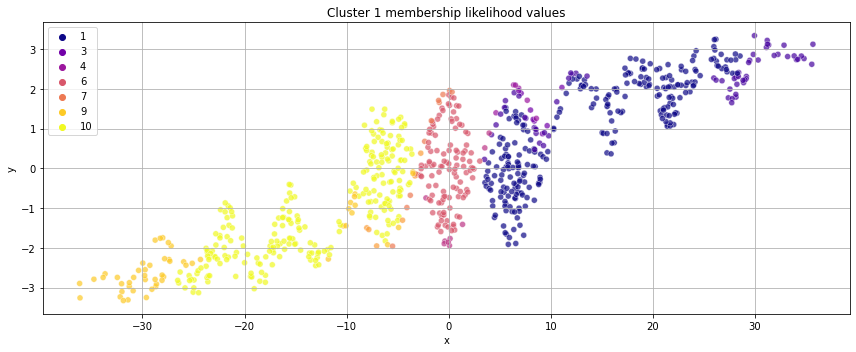

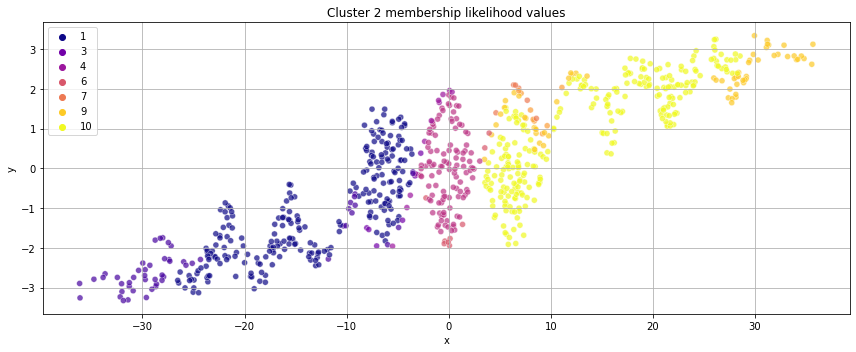

-------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------

Fuzzy partition coefficient for 3 centres: 0.7088.



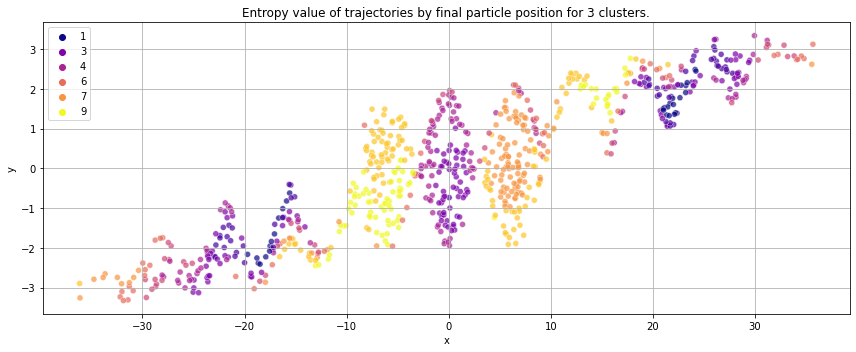

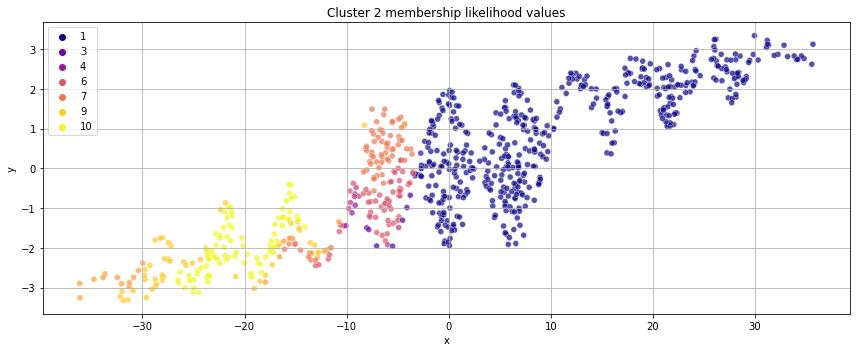

-------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------

Fuzzy partition coefficient for 4 centres: 0.6709.



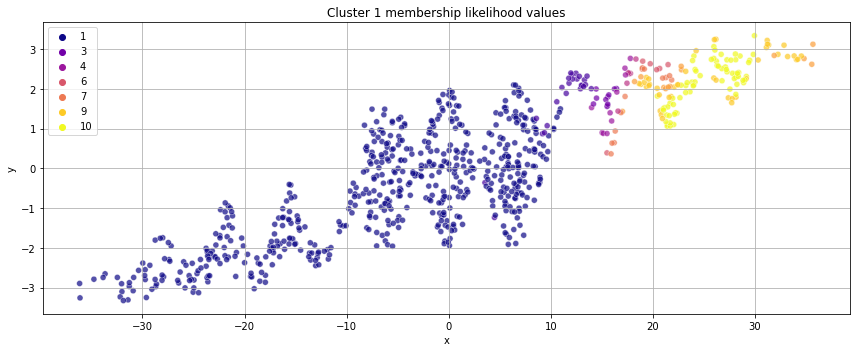

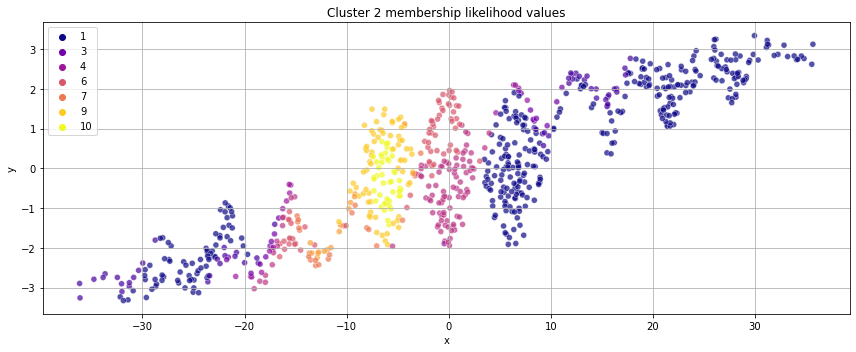

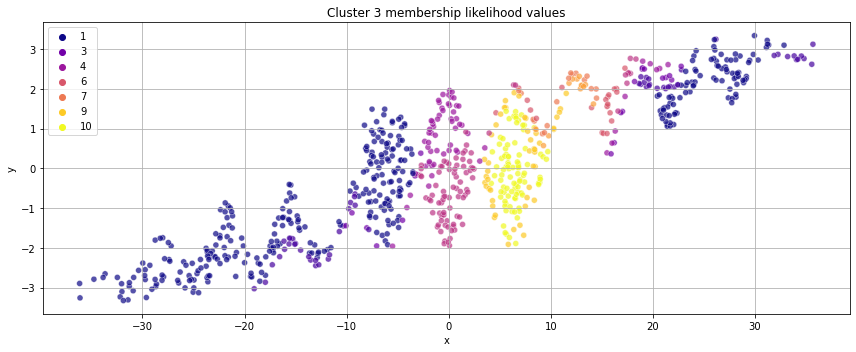

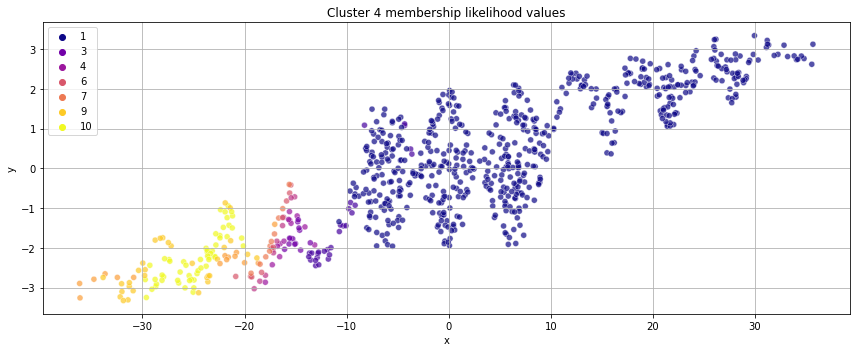

-------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------

Fuzzy partition coefficient for 5 centres: 0.6807.



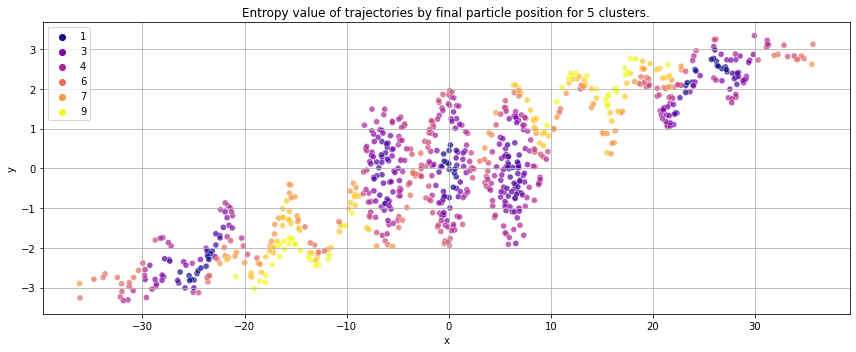

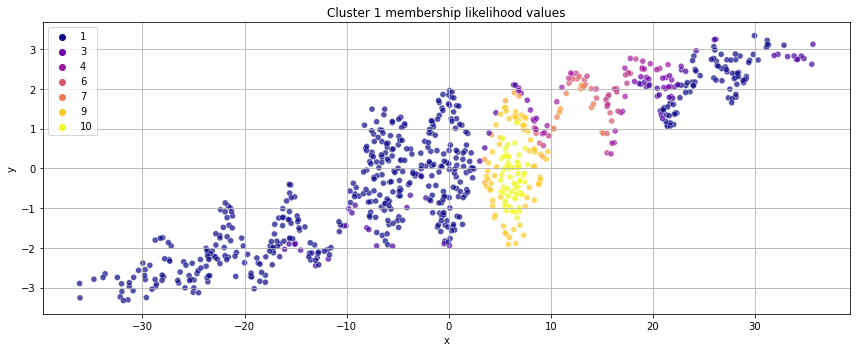

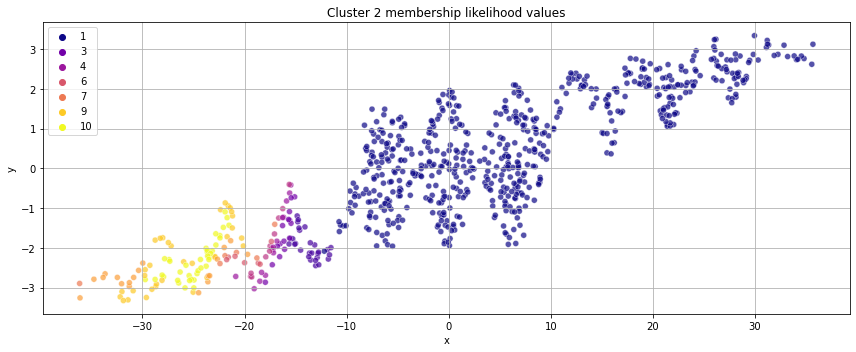

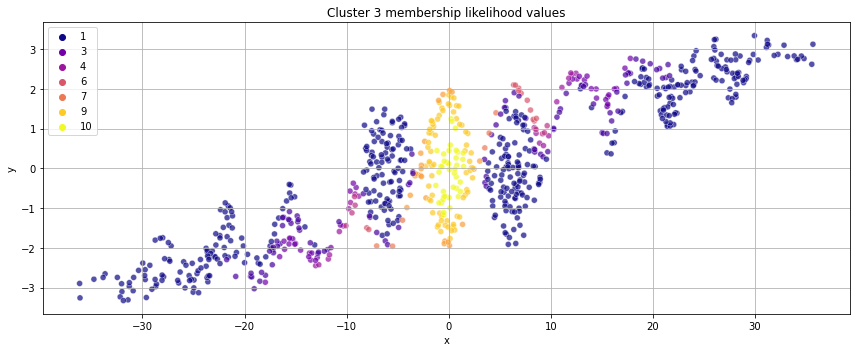

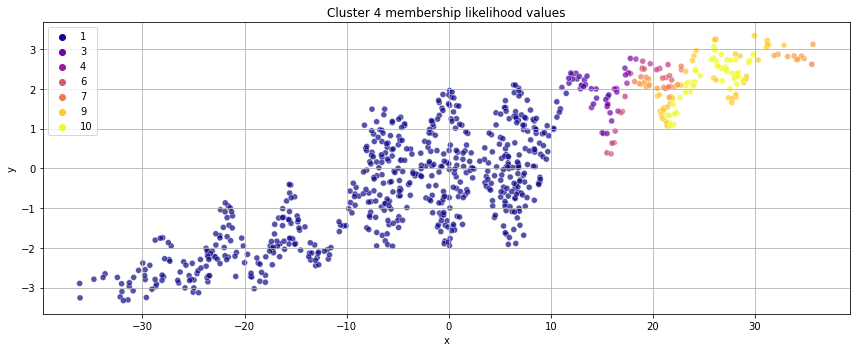

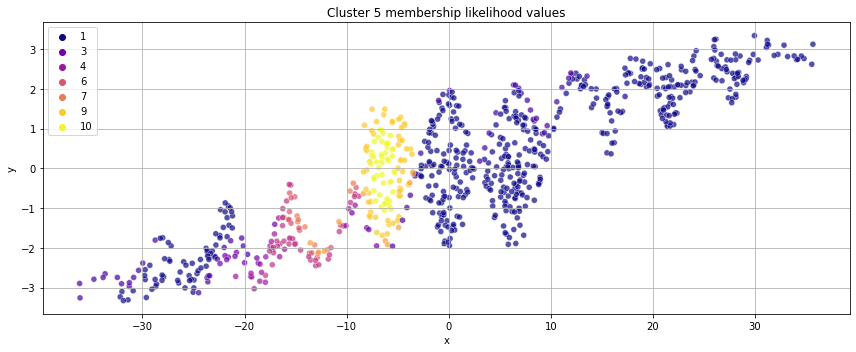

-------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------

Fuzzy partition coefficient for 6 centres: 0.6524.



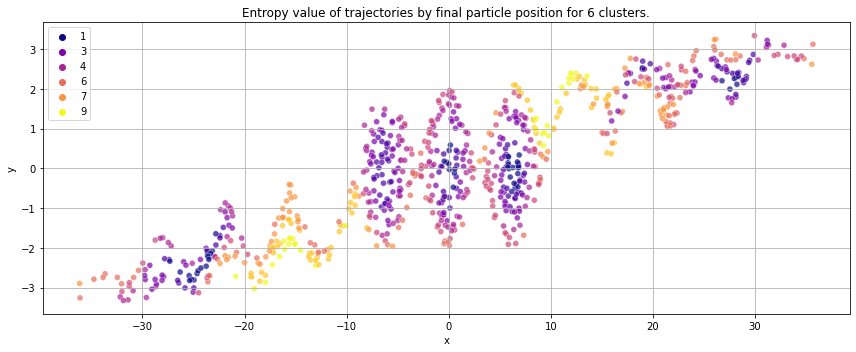

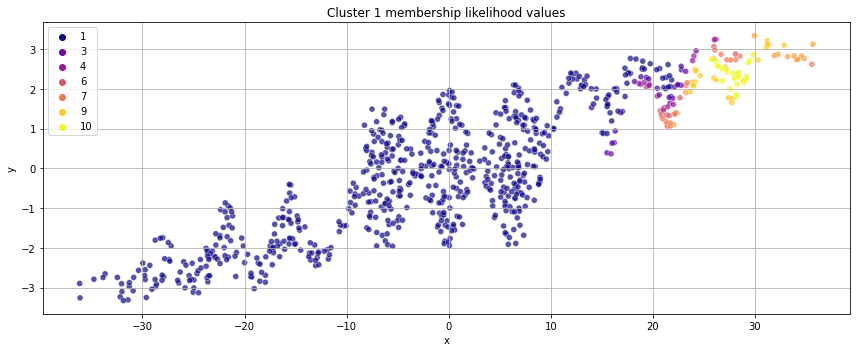

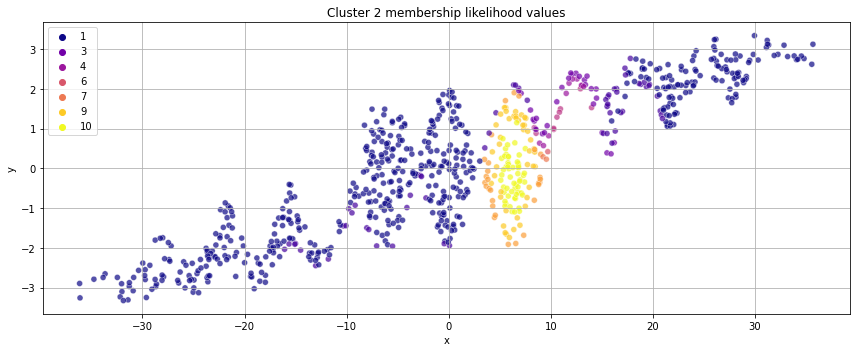

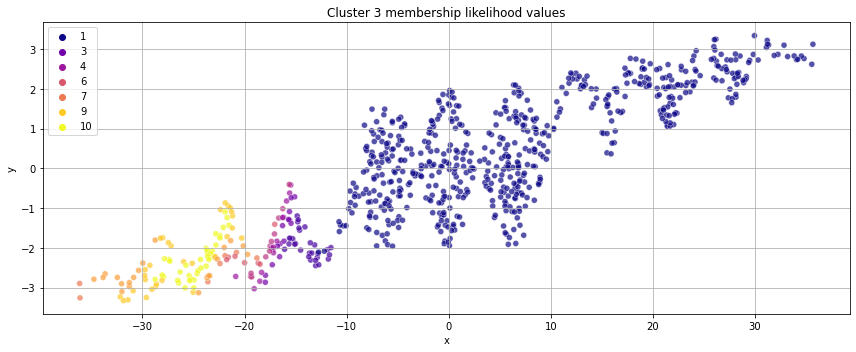

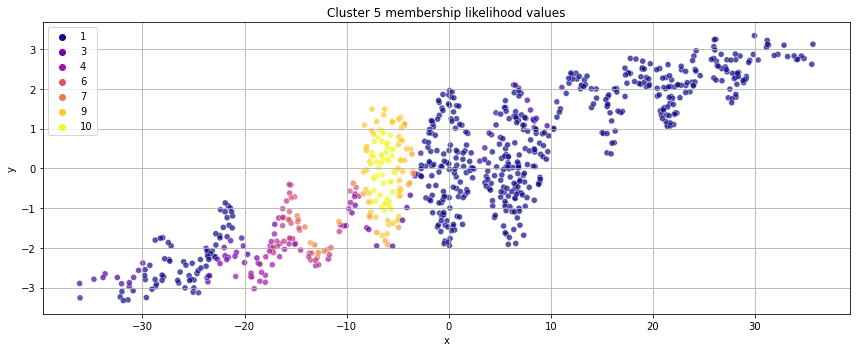

-------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------

Fuzzy partition coefficient for 7 centres: 0.6451.



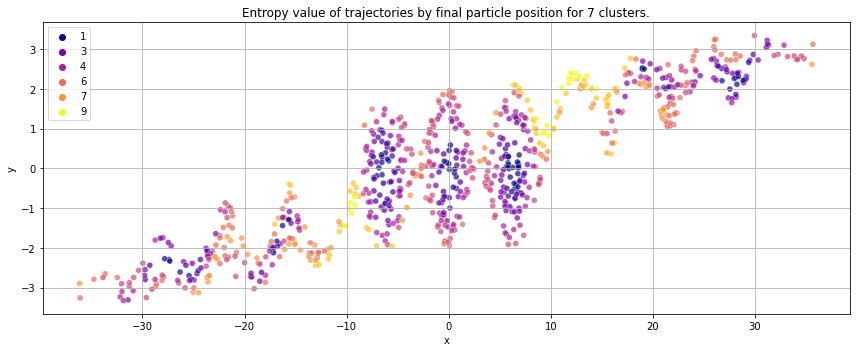

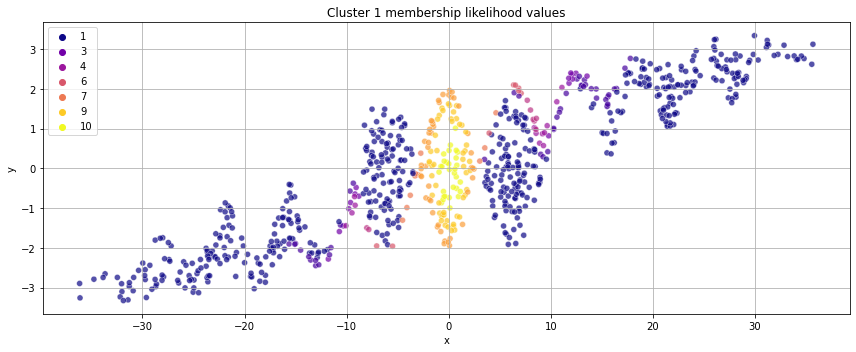

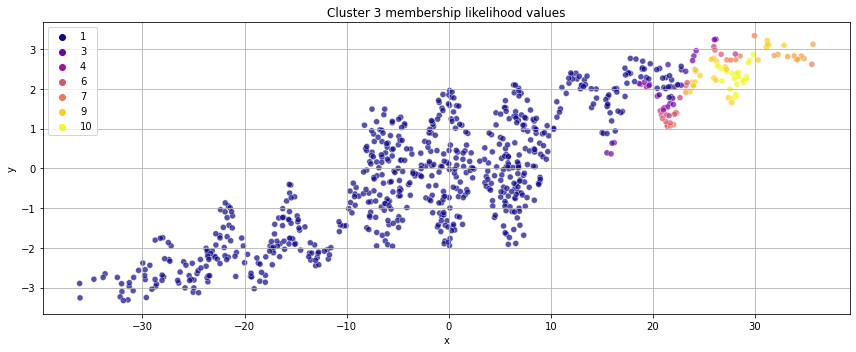

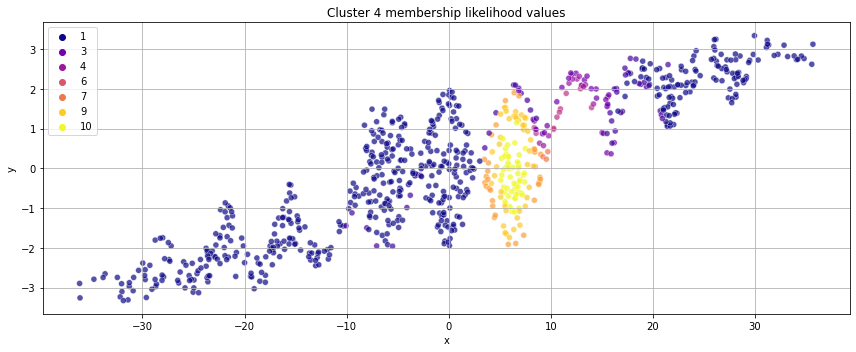

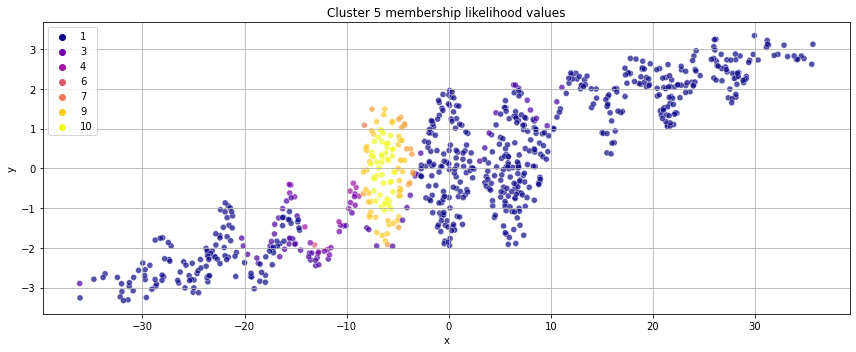

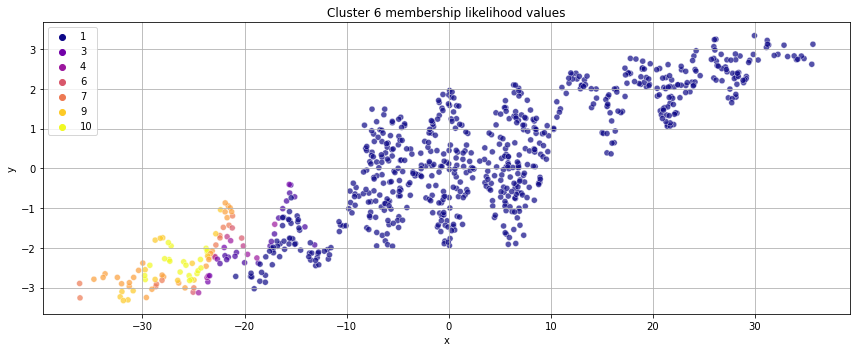

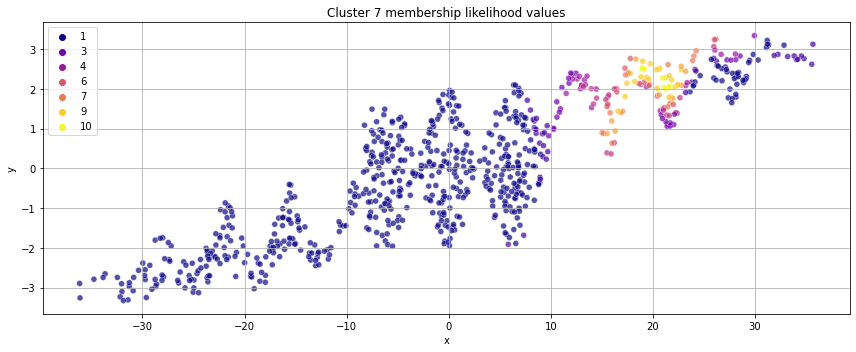

-------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------

Fuzzy partition coefficient for 8 centres: 0.6291.



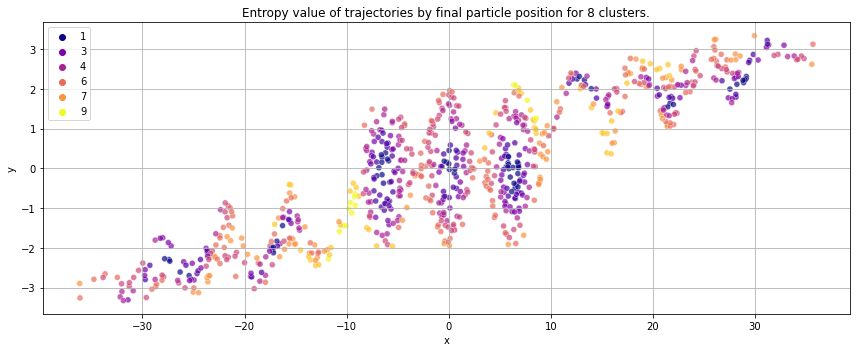

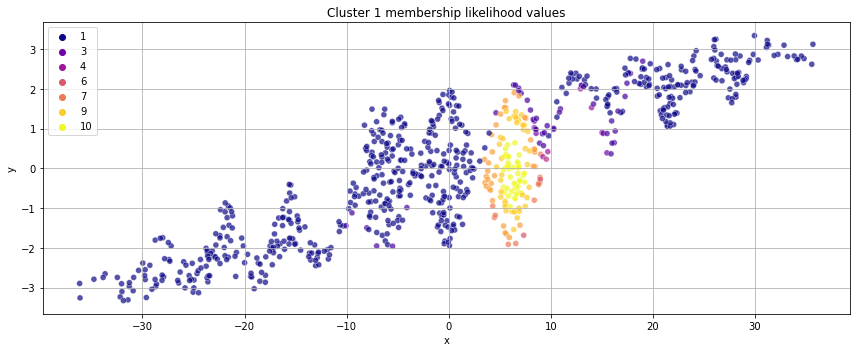

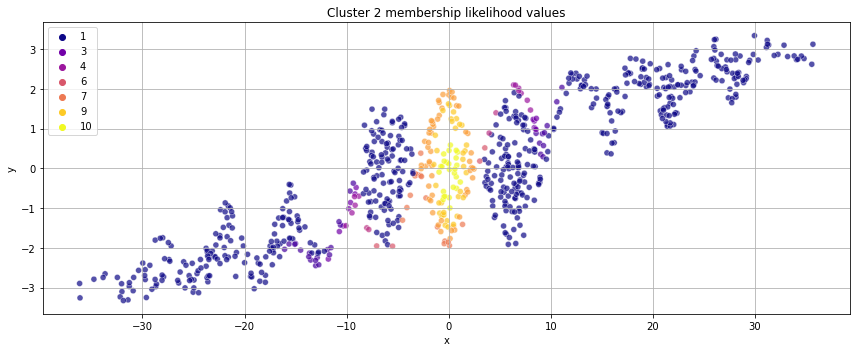

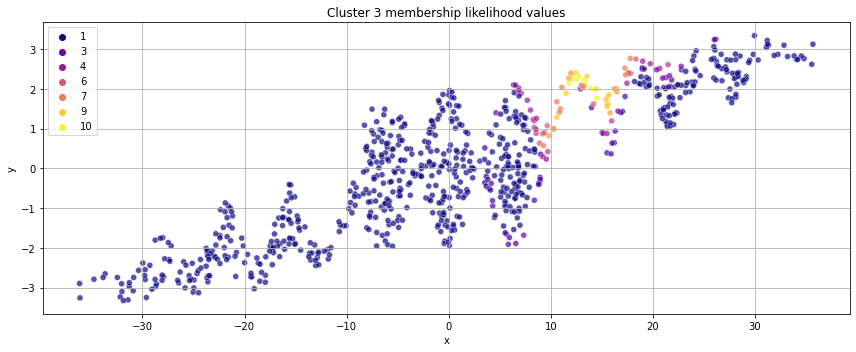

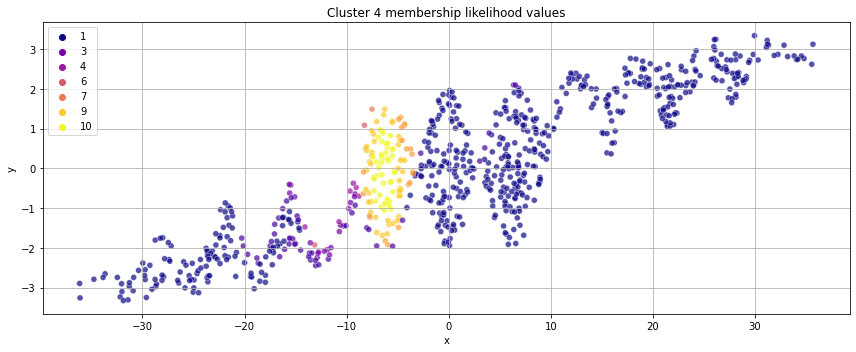

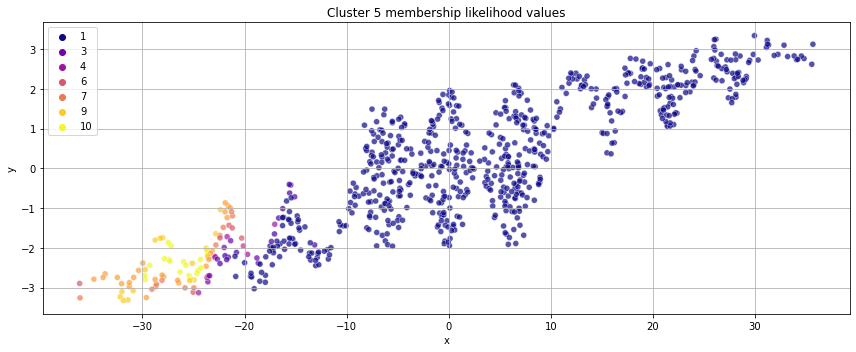

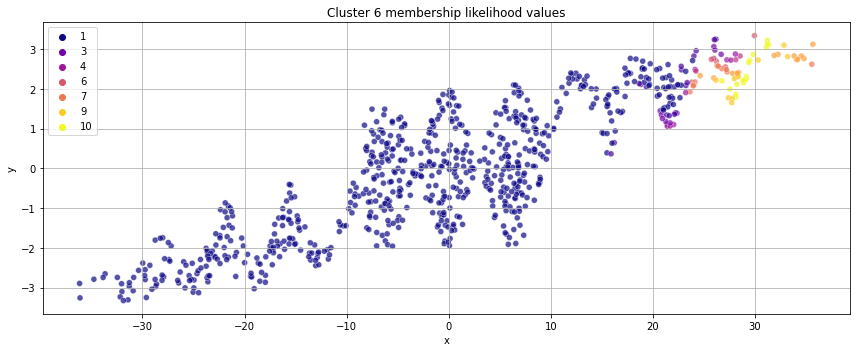

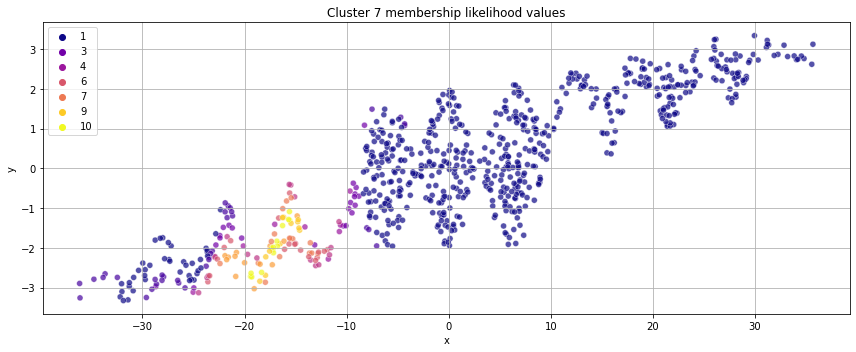

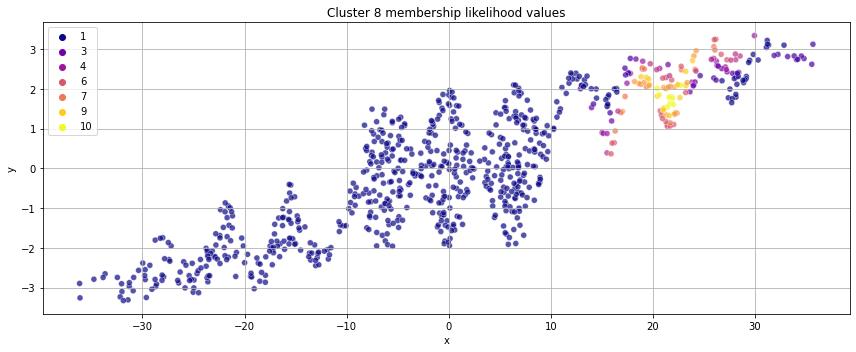

-------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------



In [16]:
# number of clusters
no_clusters_list = [2,3,4,5,6,7,8]

x_dat = x_pos[-1]
y_dat = y_pos[-1]

# graphing original positions
# x_dat = x_pos[0]
# y_dat = y_pos[0]

# loop through number of clusters
for no_clusters in no_clusters_list:
    
    # fuzzy c-means
    fuzzy_result = fuzz.cluster.cmeans(traj_mat.T,
                              no_clusters,
                              m=2,
                              error=10**(-3),
                              maxiter= 10**3)
    
    # print fuzzy coefficient
    print(f'Fuzzy partition coefficient for {no_clusters} centres: {np.round(fuzzy_result[-1],4)}.\n')
    
    # get likelihood matrix
    u = fuzzy_result[1].T

    # calculate entropy
    entropy = np.apply_along_axis(entropy_calc, 1, u)

    # create bins
    bins = np.linspace(0, max(entropy)+0.01, 10)

    # bin u values
    entropy_binned = np.digitize(entropy, bins)

    # plotting
    plt.figure(figsize=(12,5))

    # plot data
    sns.scatterplot(x=x_dat,
                    y=y_dat,
                    hue=entropy_binned,
                    palette='plasma',
                    alpha=0.7)

    plt.title(f'Entropy value of trajectories by final particle position for {no_clusters} clusters.')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()
    plt.tight_layout()

    plt.show()
    
    plot_cluster_likelihoods(x_dat, y_dat, u)
    
    print('--------------------------------------------------------------------------------------------------\n')
          
